<a href="https://colab.research.google.com/github/ADIthaker/Credit-Card-Fraud-Detection/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d mlg-ulb/creditcardfraud

 86% 57.0M/66.0M [00:00<00:00, 56.3MB/s]
100% 66.0M/66.0M [00:00<00:00, 90.4MB/s]


In [2]:
! unzip -q creditcardfraud.zip

In [3]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip
'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline
'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
'''Algos'''
import lightgbm as lgb
'''TensorFlow and Keras'''
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy

In [4]:
curr_path = os.getcwd()
file = '/creditcard.csv'
data = pd.read_csv(curr_path + file)

In [5]:
dataX = data.copy().drop(['Class','Time'],axis=1)
dataY = data['Class'].copy()
featuresToScale = dataX.columns
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
X_train, X_test, y_train, y_test = \
train_test_split(dataX, dataY, test_size=0.33, \
random_state=2018, stratify=dataY)
X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

In [6]:
def anomalyScores(originalDF, reducedDF):
  loss = np.sum((np.array(originalDF) - \
  np.array(reducedDF))**2, axis=1)
  loss = pd.Series(data=loss,index=originalDF.index)
  loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
  return loss

In [17]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
  preds = pd.concat([trueLabels, anomalyScores], axis=1)
  preds.columns = ['trueLabel', 'anomalyScore']
  precision, recall, thresholds = \
  precision_recall_curve(preds['trueLabel'], \
  preds['anomalyScore'])
  average_precision = average_precision_score( \
  preds['trueLabel'], preds['anomalyScore'])
  plt.step(recall, precision, color='k', alpha=0.7, where='post')
  plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.ylim([0.0, 1.05])
  plt.xlim([0.0, 1.0])
  plt.title('Precision-Recall curve: Average Precision = \
  {0:0.2f}'.format(average_precision))
  fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
  preds['anomalyScore'])
  areaUnderROC = auc(fpr, tpr)
  plt.figure()
  plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
  plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic: Area under the \
  curve = {0:0.2f}'.format(areaUnderROC))
  plt.legend(loc="lower right")
  plt.show()
  if returnPreds==True:
    return preds, average_precision

## Simple Complete Autoencoder

In [9]:
model = Sequential()
model.add(Dense(units=29, activation='linear',input_dim=29))
model.add(Dense(units=29, activation='linear'))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [10]:
history = model.fit(x=X_train_AE, y=X_train_AE,epochs=10,batch_size=32,shuffle=True,validation_data=(X_train_AE,X_train_AE),verbose=2)

Epoch 1/10
5964/5964 - 28s - loss: 0.0777 - accuracy: 0.9053 - val_loss: 0.0022 - val_accuracy: 0.9821
Epoch 2/10
5964/5964 - 14s - loss: 5.7555e-04 - accuracy: 0.9937 - val_loss: 0.0020 - val_accuracy: 0.9843
Epoch 3/10
5964/5964 - 14s - loss: 7.9664e-04 - accuracy: 0.9936 - val_loss: 1.5062e-08 - val_accuracy: 0.9999
Epoch 4/10
5964/5964 - 15s - loss: 7.0475e-04 - accuracy: 0.9941 - val_loss: 1.6330e-05 - val_accuracy: 0.9984
Epoch 5/10
5964/5964 - 19s - loss: 5.3896e-04 - accuracy: 0.9948 - val_loss: 2.3639e-05 - val_accuracy: 0.9986
Epoch 6/10
5964/5964 - 14s - loss: 5.9976e-04 - accuracy: 0.9933 - val_loss: 1.4527e-04 - val_accuracy: 0.9966
Epoch 7/10
5964/5964 - 14s - loss: 4.0236e-04 - accuracy: 0.9953 - val_loss: 7.9305e-04 - val_accuracy: 0.9873
Epoch 8/10
5964/5964 - 14s - loss: 5.8521e-04 - accuracy: 0.9942 - val_loss: 1.8810e-04 - val_accuracy: 0.9962
Epoch 9/10
5964/5964 - 15s - loss: 5.4165e-04 - accuracy: 0.9935 - val_loss: 1.8325e-07 - val_accuracy: 0.9999
Epoch 10/10
5

2938/2938 [==============================] - 3s 921us/step


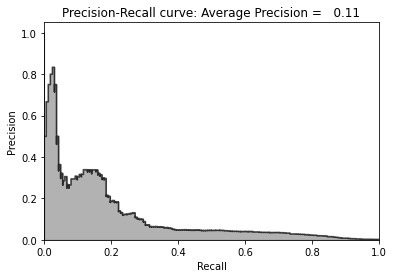

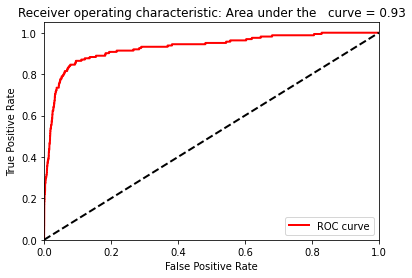

In [11]:
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

2938/2938 [==============================] - 3s 951us/step


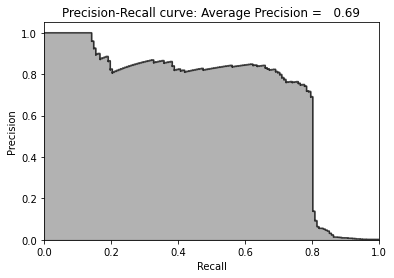

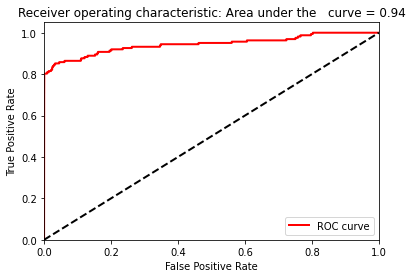

2938/2938 [==============================] - 3s 991us/step


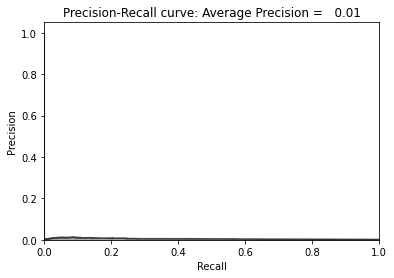

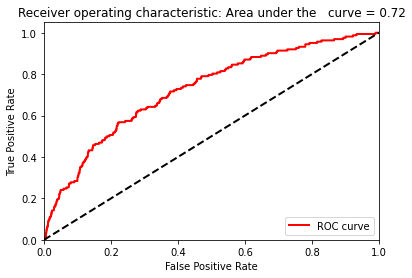

2938/2938 [==============================] - 3s 1ms/step


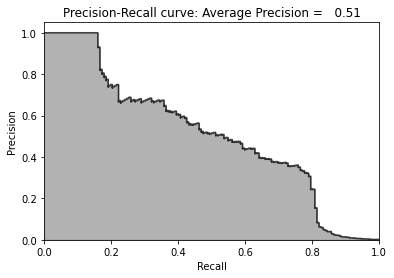

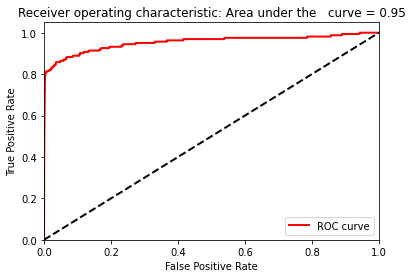

2938/2938 [==============================] - 3s 937us/step


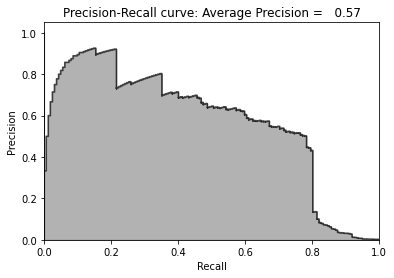

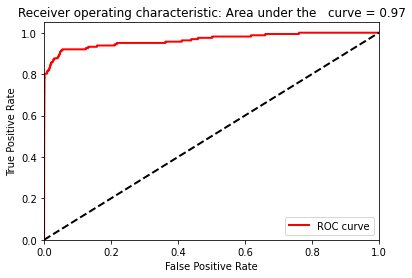

2938/2938 [==============================] - 3s 1ms/step


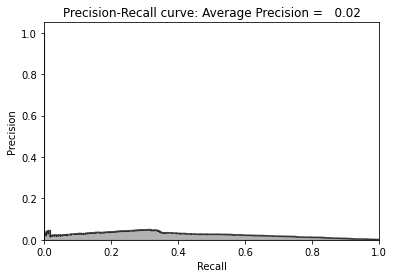

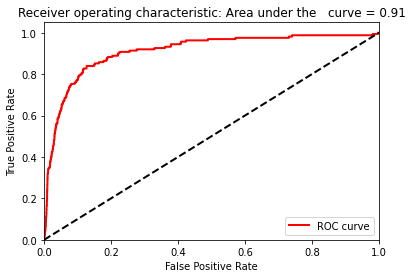

2938/2938 [==============================] - 3s 970us/step


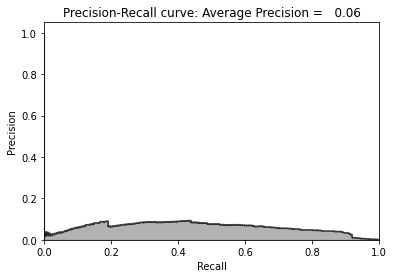

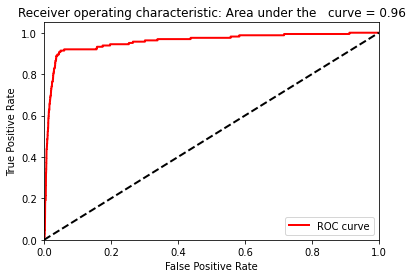

2938/2938 [==============================] - 3s 959us/step


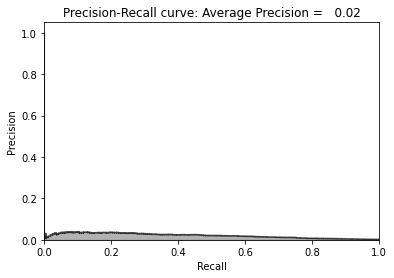

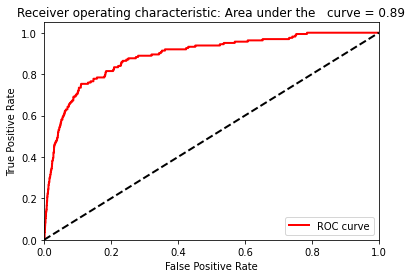

2938/2938 [==============================] - 3s 1ms/step


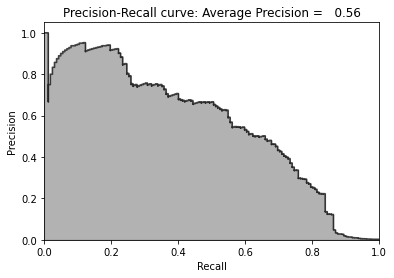

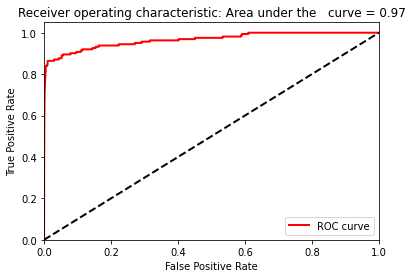

2938/2938 [==============================] - 3s 978us/step


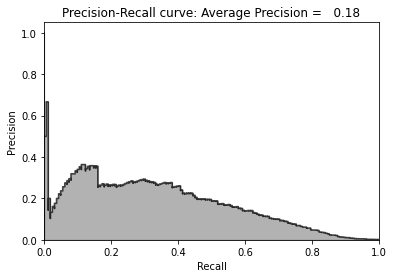

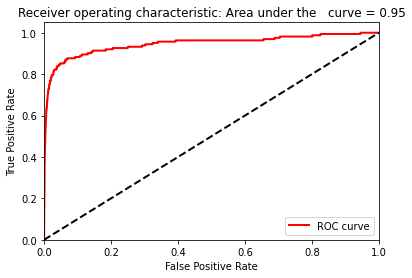

2938/2938 [==============================] - 3s 983us/step


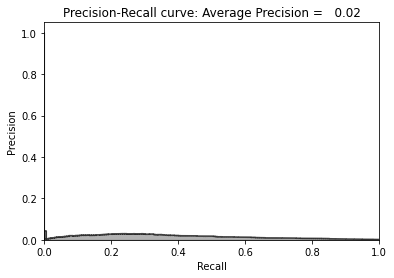

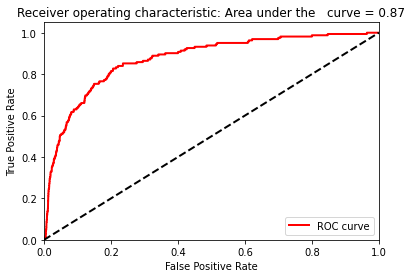

Mean average precision over 10 runs:  0.26423697532717505


[0.694374580951476,
 0.005169836417217056,
 0.5135372532046462,
 0.5678440593484956,
 0.024704630812691555,
 0.060699318852814384,
 0.020498295713538266,
 0.5632775839008866,
 0.17675255231133893,
 0.01551164175864567]

In [18]:
test_scores = []
for i in range(0,10):
  model = Sequential()
  model.add(Dense(units=29, activation='linear',input_dim=29))
  model.add(Dense(units=29, activation='linear'))
  model.compile(optimizer='adam',
  loss='mean_squared_error',
  metrics=['accuracy'])
  num_epochs = 10
  batch_size = 32
  history = model.fit(x=X_train_AE, y=X_train_AE,
  epochs=num_epochs,
  batch_size=batch_size,
  shuffle=True,
  validation_data=(X_train_AE, X_train_AE),
  verbose=0)
  predictions = model.predict(X_test, verbose=1)
  anomalyScoresAE = anomalyScores(X_test, predictions)
  preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
  test_scores.append(avgPrecision)
print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

## Undercomplete Autoencoder

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.3100 - accuracy: 0.6101 - val_loss: 0.0370 - val_accuracy: 0.8884
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0379 - accuracy: 0.9124 - val_loss: 0.0385 - val_accuracy: 0.9264
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0369 - accuracy: 0.9350 - val_loss: 0.0377 - val_accuracy: 0.9493
Epoch 4/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0374 - accuracy: 0.9489 - val_loss: 0.0380 - val_accuracy: 0.9449
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0373 - accuracy: 0.9510 - val_loss: 0.0371 - val_accuracy: 0.9610
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0437 - accuracy: 0.9598 - val_loss: 0.0405 - val_accuracy: 0.9576
Epoch 7/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0443 - accuracy: 0.9583 - val_loss: 0.0370 - val_ac

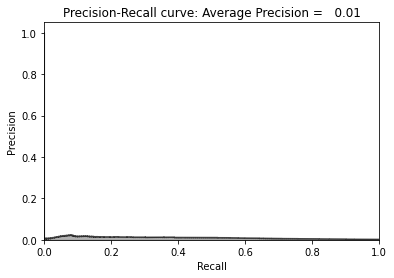

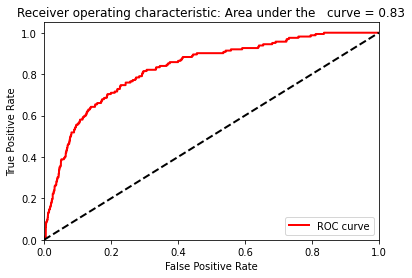

Epoch 1/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.3190 - accuracy: 0.5846 - val_loss: 0.0374 - val_accuracy: 0.8720
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0374 - accuracy: 0.8907 - val_loss: 0.0404 - val_accuracy: 0.9021
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0384 - accuracy: 0.9185 - val_loss: 0.0555 - val_accuracy: 0.9027
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0368 - accuracy: 0.9280 - val_loss: 0.0466 - val_accuracy: 0.9296
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0398 - accuracy: 0.9478 - val_loss: 0.0362 - val_accuracy: 0.9481
Epoch 6/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0346 - accuracy: 0.9504 - val_loss: 0.0369 - val_accuracy: 0.9537
Epoch 7/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0354 - accuracy: 0.9544 - val_loss: 0.0366 - val_ac

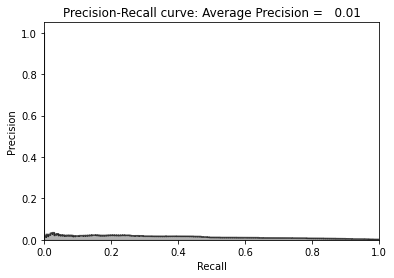

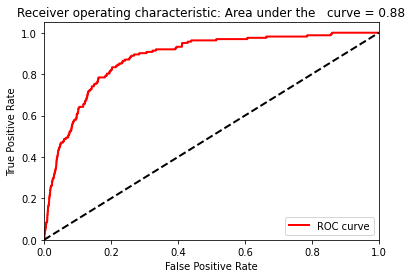

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.3306 - accuracy: 0.6333 - val_loss: 0.0358 - val_accuracy: 0.9139
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0379 - accuracy: 0.9196 - val_loss: 0.0350 - val_accuracy: 0.9305
Epoch 3/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0406 - accuracy: 0.9238 - val_loss: 0.0341 - val_accuracy: 0.9422
Epoch 4/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0367 - accuracy: 0.9395 - val_loss: 0.0342 - val_accuracy: 0.9605
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0384 - accuracy: 0.9482 - val_loss: 0.0346 - val_accuracy: 0.9599
Epoch 6/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0353 - accuracy: 0.9567 - val_loss: 0.0346 - val_accuracy: 0.9718
Epoch 7/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0352 - accuracy: 0.9497 - val_loss: 0.0340 - val_ac

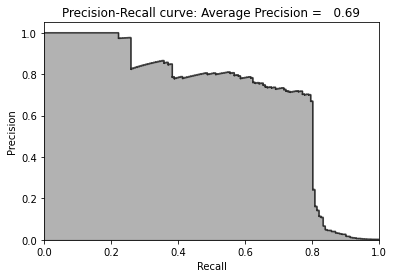

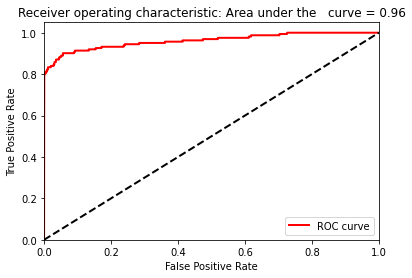

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2833 - accuracy: 0.6730 - val_loss: 0.0394 - val_accuracy: 0.9473
Epoch 2/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0358 - accuracy: 0.9499 - val_loss: 0.0381 - val_accuracy: 0.9290
Epoch 3/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0473 - accuracy: 0.9173 - val_loss: 0.0387 - val_accuracy: 0.9499
Epoch 4/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0382 - accuracy: 0.9437 - val_loss: 0.0369 - val_accuracy: 0.9617
Epoch 5/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0403 - accuracy: 0.9531 - val_loss: 0.0367 - val_accuracy: 0.9583
Epoch 6/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0342 - accuracy: 0.9526 - val_loss: 0.0379 - val_accuracy: 0.9430
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0374 - accuracy: 0.9476 - val_loss: 0.0372 - val_ac

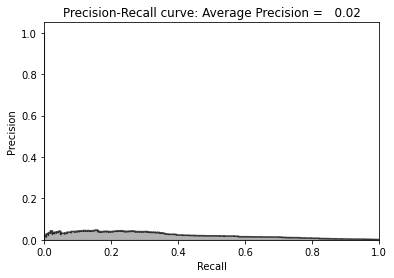

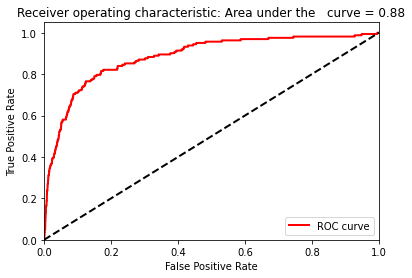

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.2926 - accuracy: 0.6558 - val_loss: 0.0367 - val_accuracy: 0.8992
Epoch 2/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0411 - accuracy: 0.8957 - val_loss: 0.0374 - val_accuracy: 0.9032
Epoch 3/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0370 - accuracy: 0.9296 - val_loss: 0.0429 - val_accuracy: 0.9297
Epoch 4/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0434 - accuracy: 0.9438 - val_loss: 0.0370 - val_accuracy: 0.9636
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0359 - accuracy: 0.9584 - val_loss: 0.0449 - val_accuracy: 0.9419
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0437 - accuracy: 0.9513 - val_loss: 0.0366 - val_accuracy: 0.9666
Epoch 7/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0392 - accuracy: 0.9579 - val_loss: 0.0370 - val_ac

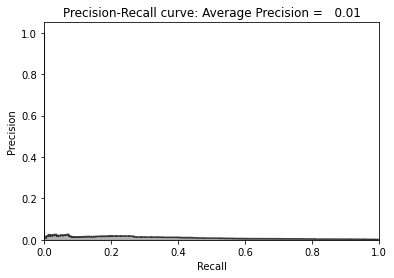

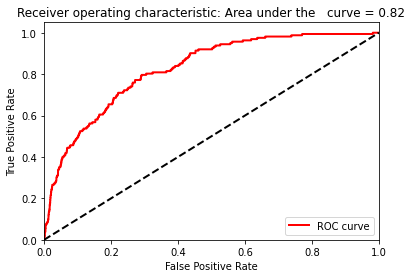

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.3439 - accuracy: 0.6345 - val_loss: 0.0367 - val_accuracy: 0.8639
Epoch 2/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0380 - accuracy: 0.8794 - val_loss: 0.0396 - val_accuracy: 0.9305
Epoch 3/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0376 - accuracy: 0.9380 - val_loss: 0.0360 - val_accuracy: 0.9533
Epoch 4/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0401 - accuracy: 0.9431 - val_loss: 0.0367 - val_accuracy: 0.9588
Epoch 5/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0395 - accuracy: 0.9498 - val_loss: 0.0363 - val_accuracy: 0.9550
Epoch 6/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0376 - accuracy: 0.9516 - val_loss: 0.0491 - val_accuracy: 0.9332
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0407 - accuracy: 0.9470 - val_loss: 0.0369 - val_ac

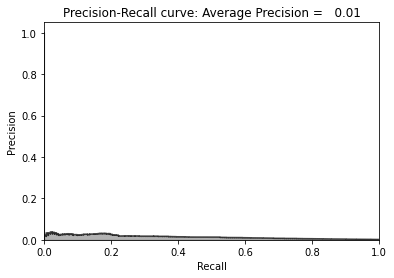

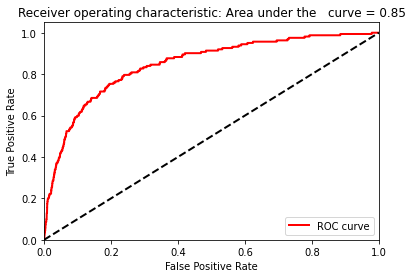

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.2739 - accuracy: 0.6564 - val_loss: 0.0364 - val_accuracy: 0.9095
Epoch 2/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0373 - accuracy: 0.9292 - val_loss: 0.0374 - val_accuracy: 0.9373
Epoch 3/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0366 - accuracy: 0.9438 - val_loss: 0.0375 - val_accuracy: 0.9555
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0383 - accuracy: 0.9514 - val_loss: 0.0367 - val_accuracy: 0.9640
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0422 - accuracy: 0.9598 - val_loss: 0.0371 - val_accuracy: 0.9646
Epoch 6/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0397 - accuracy: 0.9593 - val_loss: 0.0373 - val_accuracy: 0.9620
Epoch 7/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0350 - accuracy: 0.9610 - val_loss: 0.0395 - val_ac

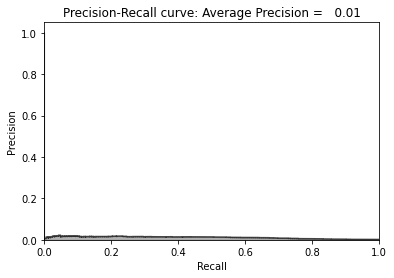

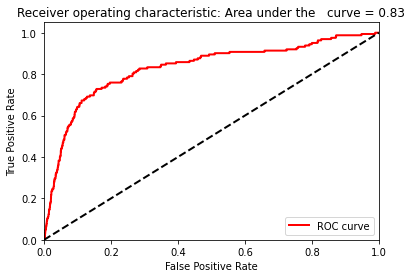

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.2932 - accuracy: 0.6530 - val_loss: 0.0400 - val_accuracy: 0.8874
Epoch 2/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0381 - accuracy: 0.8930 - val_loss: 0.0347 - val_accuracy: 0.9134
Epoch 3/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0383 - accuracy: 0.9099 - val_loss: 0.0356 - val_accuracy: 0.9358
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0294 - accuracy: 0.9541 - val_loss: 0.0356 - val_accuracy: 0.8829
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0376 - accuracy: 0.8928 - val_loss: 0.0345 - val_accuracy: 0.9299
Epoch 6/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0374 - accuracy: 0.9284 - val_loss: 0.0345 - val_accuracy: 0.9485
Epoch 7/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0370 - accuracy: 0.9459 - val_loss: 0.0348 - val_ac

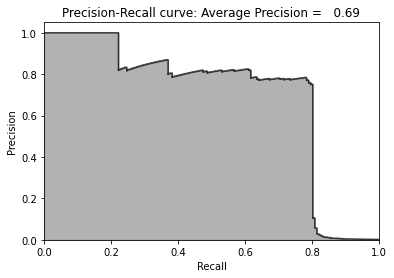

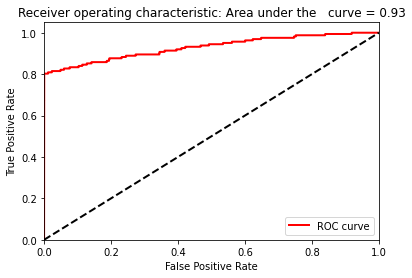

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.2913 - accuracy: 0.6685 - val_loss: 0.0519 - val_accuracy: 0.9123
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0516 - accuracy: 0.9224 - val_loss: 0.0371 - val_accuracy: 0.9317
Epoch 3/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0366 - accuracy: 0.9419 - val_loss: 0.0365 - val_accuracy: 0.9584
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0339 - accuracy: 0.9579 - val_loss: 0.0380 - val_accuracy: 0.9560
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0371 - accuracy: 0.9584 - val_loss: 0.0366 - val_accuracy: 0.9562
Epoch 6/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0348 - accuracy: 0.9534 - val_loss: 0.0370 - val_accuracy: 0.9519
Epoch 7/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0418 - accuracy: 0.9538 - val_loss: 0.0367 - val_ac

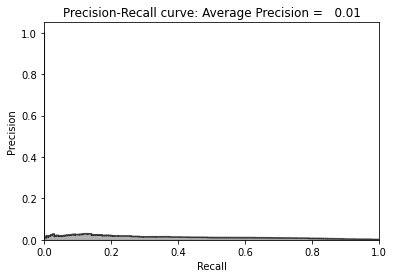

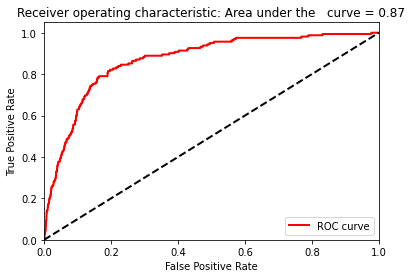

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.3711 - accuracy: 0.6229 - val_loss: 0.0369 - val_accuracy: 0.9088
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0392 - accuracy: 0.9152 - val_loss: 0.0365 - val_accuracy: 0.9358
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0388 - accuracy: 0.9399 - val_loss: 0.0375 - val_accuracy: 0.9494
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0410 - accuracy: 0.9508 - val_loss: 0.0377 - val_accuracy: 0.9539
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0355 - accuracy: 0.9523 - val_loss: 0.0366 - val_accuracy: 0.9558
Epoch 6/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0426 - accuracy: 0.9488 - val_loss: 0.0370 - val_accuracy: 0.9615
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0331 - accuracy: 0.9585 - val_loss: 0.0436 - val_ac

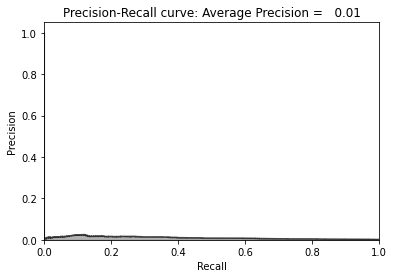

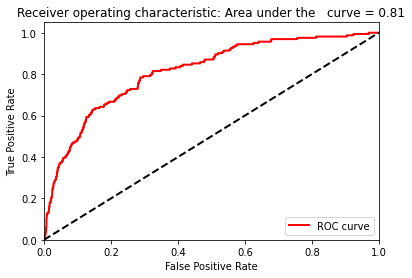

Mean average precision over 10 runs:  0.149134622029873


[0.00967541061250248,
 0.013817094934354094,
 0.692866864701494,
 0.022505535567256103,
 0.010115312103085559,
 0.014189974193450926,
 0.011433644326756342,
 0.6937486947905122,
 0.013123143173684747,
 0.009870545895633872]

In [20]:
test_scores = []
for i in range(0,10):
  model = Sequential()
  model.add(Dense(units=28, activation='linear',input_dim=29))
  model.add(Dense(units=27, activation='linear'))
  model.add(Dense(units=29, activation='linear'))
  model.compile(optimizer='adam',
  loss='mean_squared_error',
  metrics=['accuracy'])
  # Train the model
  num_epochs = 10
  batch_size = 32
  history = model.fit(x=X_train_AE, y=X_train_AE,
  epochs=num_epochs,
  batch_size=batch_size,
  shuffle=True,
  validation_data=(X_train_AE, X_train_AE),
  verbose=1)
  # Evaluate on test set
  predictions = model.predict(X_test, verbose=1)
  anomalyScoresAE = anomalyScores(X_test, predictions)
  preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)
  test_scores.append(avgPrecision)
print("Mean average precision over 10 runs: ", np.mean(test_scores))
test_scores

## Non-Linear Autoencoder

Epoch 1/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.7945 - accuracy: 0.4166 - val_loss: 0.5792 - val_accuracy: 0.7682
Epoch 2/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.5808 - accuracy: 0.7987 - val_loss: 0.5505 - val_accuracy: 0.8720
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.5544 - accuracy: 0.8652 - val_loss: 0.5455 - val_accuracy: 0.8880
Epoch 4/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.5382 - accuracy: 0.8743 - val_loss: 0.5440 - val_accuracy: 0.8777
Epoch 5/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.5642 - accuracy: 0.8680 - val_loss: 0.5323 - val_accuracy: 0.8915
Epoch 6/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.5301 - accuracy: 0.8934 - val_loss: 0.5399 - val_accuracy: 0.9047
Epoch 7/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.5275 - accuracy: 0.8963 - val_loss: 0.5396 - val_ac

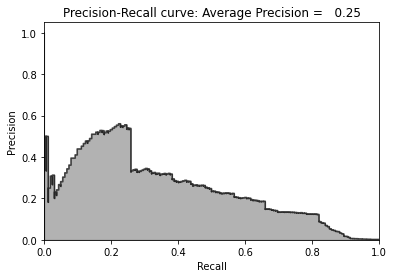

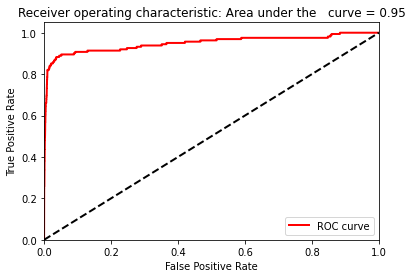

In [29]:
model = Sequential()
model.add(Dense(units=27, activation='relu',input_dim=29))
model.add(Dense(units=22, activation='relu'))
model.add(Dense(units=27, activation='relu'))
model.add(Dense(units=29, activation='relu'))
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE, y=X_train_AE,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

## Overcomplete with linear Activation

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.1862 - accuracy: 0.8133 - val_loss: 0.0016 - val_accuracy: 0.9878
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 7.5953e-04 - accuracy: 0.9929 - val_loss: 4.1964e-07 - val_accuracy: 0.9997
Epoch 3/10
5964/5964 [==============================] - 22s 4ms/step - loss: 9.5080e-04 - accuracy: 0.9920 - val_loss: 6.2191e-06 - val_accuracy: 0.9993
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 7.5972e-04 - accuracy: 0.9932 - val_loss: 2.7496e-05 - val_accuracy: 0.9979
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 9.3015e-04 - accuracy: 0.9932 - val_loss: 2.3717e-04 - val_accuracy: 0.9916
Epoch 6/10
5964/5964 [==============================] - 20s 3ms/step - loss: 9.6146e-04 - accuracy: 0.9922 - val_loss: 2.3426e-05 - val_accuracy: 0.9982
Epoch 7/10
5964/5964 [==============================] - 20s 3ms/step - loss: 6.5298e-04 - 

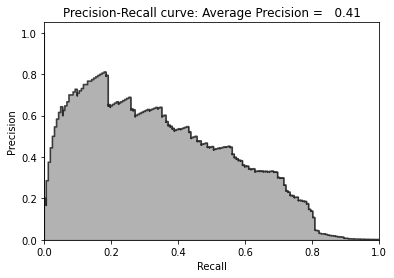

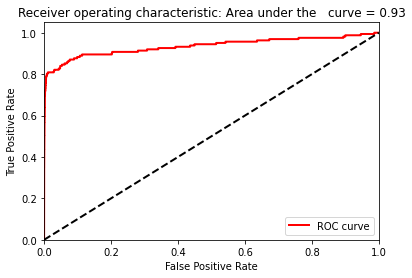

In [22]:
model = Sequential()
model.add(Dense(units=40, activation='linear',input_dim=29))
model.add(Dense(units=29, activation='linear'))
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE, y=X_train_AE,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

## Overcomplete Autoencoder with Linear Activation and Dropout

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.3460 - accuracy: 0.6252 - val_loss: 0.0097 - val_accuracy: 0.9632
Epoch 2/10
5964/5964 [==============================] - 19s 3ms/step - loss: 0.0774 - accuracy: 0.7861 - val_loss: 0.0078 - val_accuracy: 0.9752
Epoch 3/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0774 - accuracy: 0.7876 - val_loss: 0.0071 - val_accuracy: 0.9764
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0775 - accuracy: 0.7860 - val_loss: 0.0071 - val_accuracy: 0.9755
Epoch 5/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0798 - accuracy: 0.7843 - val_loss: 0.0069 - val_accuracy: 0.9796
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0770 - accuracy: 0.7858 - val_loss: 0.0078 - val_accuracy: 0.9735
Epoch 7/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0776 - accuracy: 0.7869 - val_loss: 0.0067 - val_ac

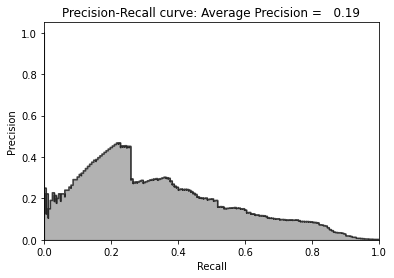

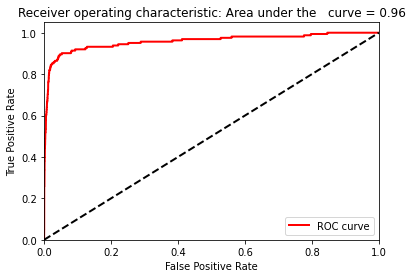

In [30]:
model = Sequential()
model.add(Dense(units=40, activation='linear', input_dim=29))
model.add(Dropout(0.10))
model.add(Dense(units=29, activation='linear'))
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE, y=X_train_AE,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

## Sparse Overcomplete Autoencoder with Linear Activation

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.2227 - accuracy: 0.7870 - val_loss: 0.0034 - val_accuracy: 0.9813
Epoch 2/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0033 - accuracy: 0.9935 - val_loss: 0.0025 - val_accuracy: 0.9953
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0028 - accuracy: 0.9934 - val_loss: 0.0044 - val_accuracy: 0.9679
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0033 - accuracy: 0.9908 - val_loss: 0.0017 - val_accuracy: 0.9945
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0024 - accuracy: 0.9930 - val_loss: 0.0017 - val_accuracy: 0.9927
Epoch 6/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0022 - accuracy: 0.9916 - val_loss: 0.0171 - val_accuracy: 0.9684
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0037 - accuracy: 0.9882 - val_loss: 0.0031 - val_ac

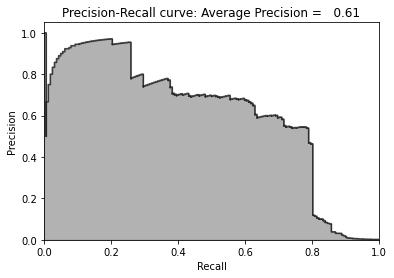

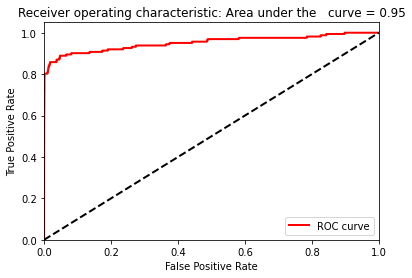

In [31]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
activity_regularizer=regularizers.l1(10e-5), input_dim=29))
model.add(Dense(units=29, activation='linear'))
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE, y=X_train_AE,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

## Sparse Overcomplete Autoencoder with Linear Activation and Dropout

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.3053 - accuracy: 0.6679 - val_loss: 0.0073 - val_accuracy: 0.9805
Epoch 2/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0408 - accuracy: 0.8608 - val_loss: 0.0068 - val_accuracy: 0.9796
Epoch 3/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0424 - accuracy: 0.8600 - val_loss: 0.0103 - val_accuracy: 0.9610
Epoch 4/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0406 - accuracy: 0.8601 - val_loss: 0.0043 - val_accuracy: 0.9823
Epoch 5/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0406 - accuracy: 0.8598 - val_loss: 0.0045 - val_accuracy: 0.9815
Epoch 6/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0380 - accuracy: 0.8614 - val_loss: 0.0044 - val_accuracy: 0.9825
Epoch 7/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0400 - accuracy: 0.8604 - val_loss: 0.0040 - val_ac

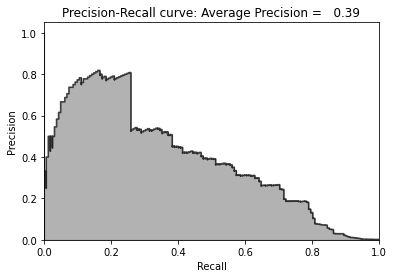

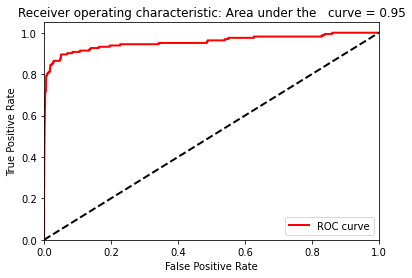

In [32]:
model = Sequential()
model.add(Dense(units=40, activation='linear', \
activity_regularizer=regularizers.l1(10e-5), input_dim=29))
model.add(Dropout(0.05))
model.add(Dense(units=29, activation='linear'))
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE, y=X_train_AE,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

## Denoising Autoencoders

In [33]:
noise_factor = 0.50
X_train_AE_noisy = X_train_AE.copy() + noise_factor * \
np.random.normal(loc=0.0, scale=1.0, size=X_train_AE.shape)
X_test_AE_noisy = X_test_AE.copy() + noise_factor * \
np.random.normal(loc=0.0, scale=1.0, size=X_test_AE.shape)

### Undercomplete

Epoch 1/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.4336 - accuracy: 0.6229 - val_loss: 0.0358 - val_accuracy: 0.9179
Epoch 2/10
5964/5964 [==============================] - 19s 3ms/step - loss: 0.0529 - accuracy: 0.8844 - val_loss: 0.0385 - val_accuracy: 0.9557
Epoch 3/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0511 - accuracy: 0.9098 - val_loss: 0.0369 - val_accuracy: 0.9274
Epoch 4/10
5964/5964 [==============================] - 19s 3ms/step - loss: 0.0515 - accuracy: 0.8932 - val_loss: 0.0372 - val_accuracy: 0.9554
Epoch 5/10
5964/5964 [==============================] - 19s 3ms/step - loss: 0.0512 - accuracy: 0.9077 - val_loss: 0.0370 - val_accuracy: 0.9539
Epoch 6/10
5964/5964 [==============================] - 21s 3ms/step - loss: 0.0520 - accuracy: 0.9090 - val_loss: 0.0368 - val_accuracy: 0.9529
Epoch 7/10
5964/5964 [==============================] - 20s 3ms/step - loss: 0.0478 - accuracy: 0.9093 - val_loss: 0.0367 - val_ac

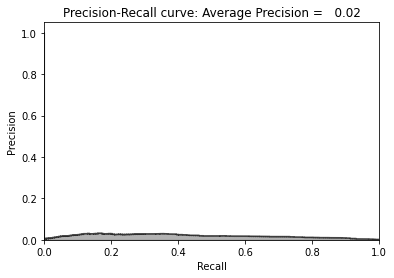

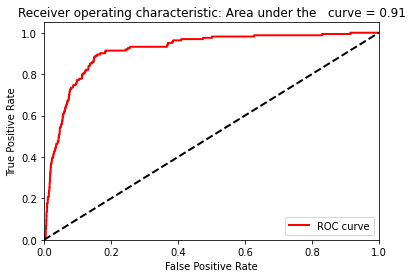

In [35]:
model = Sequential()
# Generate hidden layer with 27 nodes using linear activation
model.add(Dense(units=27, activation='linear', input_dim=29))
# Generate output layer with 29 nodes
model.add(Dense(units=29, activation='linear'))
# Compile the model
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

### Overcomplete

Epoch 1/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.3307 - accuracy: 0.6722 - val_loss: 0.0041 - val_accuracy: 0.9853
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0513 - accuracy: 0.8488 - val_loss: 0.0072 - val_accuracy: 0.9694
Epoch 3/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.0506 - accuracy: 0.8471 - val_loss: 0.0039 - val_accuracy: 0.9836
Epoch 4/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.0501 - accuracy: 0.8466 - val_loss: 0.0049 - val_accuracy: 0.9833
Epoch 5/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0494 - accuracy: 0.8471 - val_loss: 0.0047 - val_accuracy: 0.9791
Epoch 6/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.0503 - accuracy: 0.8485 - val_loss: 0.0038 - val_accuracy: 0.9822
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.0496 - accuracy: 0.8489 - val_loss: 0.0036 - val_ac

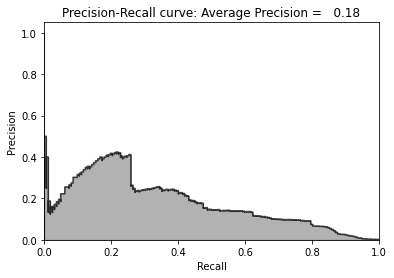

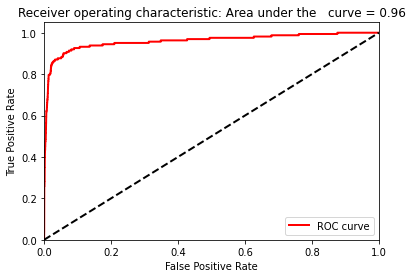

In [36]:
model = Sequential()
model.add(Dense(units=40, activation='linear',
activity_regularizer=regularizers.l1(10e-5),
input_dim=29))
model.add(Dropout(0.05))
model.add(Dense(units=29, activation='linear'))
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

#### ReLu

Epoch 1/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.9895 - accuracy: 0.4541 - val_loss: 0.5500 - val_accuracy: 0.8403
Epoch 2/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.7234 - accuracy: 0.7384 - val_loss: 0.5443 - val_accuracy: 0.8483
Epoch 3/10
5964/5964 [==============================] - 25s 4ms/step - loss: 0.6956 - accuracy: 0.7925 - val_loss: 0.5479 - val_accuracy: 0.8330
Epoch 4/10
5964/5964 [==============================] - 21s 4ms/step - loss: 0.6785 - accuracy: 0.8414 - val_loss: 0.5168 - val_accuracy: 0.9237
Epoch 5/10
5964/5964 [==============================] - 23s 4ms/step - loss: 0.6792 - accuracy: 0.8868 - val_loss: 0.5158 - val_accuracy: 0.9295
Epoch 6/10
5964/5964 [==============================] - 22s 4ms/step - loss: 0.6619 - accuracy: 0.8920 - val_loss: 0.5154 - val_accuracy: 0.9245
Epoch 7/10
5964/5964 [==============================] - 24s 4ms/step - loss: 0.6647 - accuracy: 0.8932 - val_loss: 0.5151 - val_ac

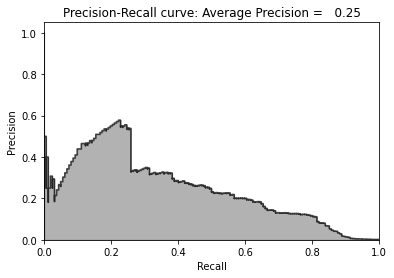

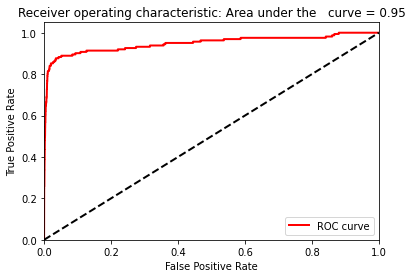

In [37]:
model = Sequential()
model.add(Dense(units=40, activation='relu',
activity_regularizer=regularizers.l1(10e-5),
input_dim=29))
model.add(Dropout(0.05))
model.add(Dense(units=29, activation='relu'))
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])
history = model.fit(x=X_train_AE_noisy, y=X_train_AE_noisy,
epochs=10,
batch_size=32,
shuffle=True,
validation_data=(X_train_AE, X_train_AE),
verbose=1)
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)